<a href="https://colab.research.google.com/github/flecaros-mbari/laser-segmentation/blob/main/U_Net_highresolution_nonilluminated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conecting with drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing libraries

In [ ]:
import torch
from scipy.spatial.distance import directed_hausdorff
from scipy.linalg import norm
from scipy import sum, average
import sys
import time
import openpyxl as pxl
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow
import glob
import pandas as pd
from tqdm.notebook import tqdm_notebook

# Pytorh
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import BCEWithLogitsLoss,HingeEmbeddingLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import keras
import keras.backend as K
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from ipywidgets                      import interact

# Erasing the caché

In [ ]:
torch.cuda.empty_cache()

# Setting parameters

Seeting the paths for training, setting the porcentages of training and validation.

In [ ]:
"""

Here we have 3 datasets:

This one is without blurry images:
IMAGE_DATASET_PATH = "/content/drive/MyDrive/2021_FernandaLecaros/DataSet_240x480/png light clean/"

This one is with blurry images:
IMAGE_DATASET_PATH = "/content/drive/MyDrive/2021_FernandaLecaros/DataSet_240x480/png_light_blurry/"

Whis one is the masks created with the depth camera:
MASK_DATASET_PATH = "/content/drive/MyDrive/2021_FernandaLecaros/DataSet_240x480/Mask clean pixeles/"

"""

# Dataset to use:
IMAGE_DATASET_PATH = "/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/"

MASK_DATASET_PATH = "/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_mask/"

# Define the path to the base output directory of the net
BASE_OUTPUT= "/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC"

# Path to the output images
SAVE_PATH = "/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC"

# Name of the test
TEST_NAME =   "highresolution_nonilluminated"

# Define the test split
TEST_SPLIT = 0.2

# Define the validation split
VAL_SPLIT = 0.1

# Determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

Here we set the number of channels, learning rate, epochs, batches, the shape of the images , threshold and the output path to save the images and trained model.


In [ ]:
# Define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 1
NUM_LEVELS = 4

# Initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 5
parameter = 1

# define the input image dimensions
INPUT_IMAGE_WIDTH = 1920
INPUT_IMAGE_HEIGHT = 1080

# define threshold to filter weak predictions
THRESHOLD = 0.15

# define the path to the output serialized model, model training
# plot, and testing image paths
lr=INIT_LR
n = NUM_EPOCHS
b = BATCH_SIZE

# name for saving
MODEL_PATH = os.path.join(BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.pth".format(TEST_NAME, parameter, n, b, THRESHOLD))
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.png".format(TEST_NAME, parameter, n, b, THRESHOLD)])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.txt".format(TEST_NAME, parameter, n, b, THRESHOLD)])




# Dataset class

In [ ]:
# Dataset Segmentation class

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):

		# Store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):

		# Return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):

		# Grab the image path from the current index
		imagePath = self.imagePaths[idx]

		# Load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)

		# Check to see if we are applying any transformations
		if self.transforms is not None:
			# Apply the transformations to image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)

		# Return a tuple of the image and its mask
		return (image, mask)

# Block, Encoder and Decoder class


In [ ]:
class Block(Module):

	def __init__(self, inChannels, outChannels):
		super().__init__()

		# Store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)

	def forward(self, x):

		# Apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()

		# Store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

		# Pooling
		self.pool = MaxPool2d(2)

	def forward(self, x):

		# initialize an empty list to store the intermediate outputs
		blockOutputs = []

		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)

		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

# U-Net class

In [ ]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16),nbClasses=1, retainDim=True, outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)

		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):

		# grab the features from the encoder
		encFeatures = self.encoder(x)

		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])

		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)

		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them

		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map


# Setting the trining and testing


In [ ]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
maskPaths = [MASK_DATASET_PATH + os.path.basename(name) for name in imagePaths if MASK_DATASET_PATH + os.path.basename(name) in maskPaths]
imagePaths = [IMAGE_DATASET_PATH + os.path.basename(name) for name in maskPaths ]

# checking paths
print(imagePaths)
print(maskPaths)

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,test_size= TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testvalImages) = split[:2]
(trainMasks, testvalMasks) = split[2:]

# Validation
VAL_SPLIT = 0.5

# Datsets test/validation
x_test, x_validation, y_test, y_validation = train_test_split(testvalImages, testvalMasks, test_size=VAL_SPLIT, random_state=42)

testImages = x_test
testMasks = y_test

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

['/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-126.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-128.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-130.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-132.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-133.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-134.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-136.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-137.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonilluminated/1-138.png', '/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/SYNTETIC/Data/1920_nonill

# Loading the dataset

In [ ]:
# define transformations
# transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),transforms.ToTensor()])
transforms = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# Create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 345 examples in the training set...
[INFO] found 43 examples in the test set...


# Loss fucntions

Some options to try in the net



In [ ]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)


        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, real_points, estimate_points):

        estimate_points = F.sigmoid(estimate_points)*255

        distancia = 0
        nan = 0
        white_real = []
        for col in range(len(real_points[0])):
          if 255 in real_points[:,col]:
            white_real.append(np.where(real_points[:,col] == 255)[0][0])
          else:
            white_real.append(-1)

        # Column
        for col in range(len(real_points[0])):
          if estimate_points[:,col].any() > 125 and white_real[col] != -1:
            white_predicted = [i for i, e in enumerate(estimate_points[:,col]) if e > 125]
            distance = [(white_real[col] - i)**2 for i in white_predicted]
            distancia += sum(distance)/len(distance )
          else:
            nan +=1


        distancia += nan*(len(real_points[0]))**4

        return torch.tensor(np.sqrt(distancia), requires_grad=True)

#PyTorch
ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, eps=1e-9):

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        inputs = torch.clamp(inputs, eps, 1.0 - eps)
        out = - (ALPHA * ((targets * torch.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)

        return combo

class WeightedHausdorffDistance(nn.Module):
    def __init__(self,
                 resized_height, resized_width,
                 p=-9,
                 return_2_terms=False,
                 device=torch.device('cpu')):
        """
        :param resized_height: Number of rows in the image.
        :param resized_width: Number of columns in the image.
        :param p: Exponent in the generalized mean. -inf makes it the minimum.
        :param return_2_terms: Whether to return the 2 terms
                               of the WHD instead of their sum.
                               Default: False.
        :param device: Device where all Tensors will reside.
        """
        super(nn.Module, self).__init__()

        # Prepare all possible (row, col) locations in the image
        self.height, self.width = resized_height, resized_width
        self.resized_size = torch.tensor([resized_height,
                                          resized_width],
                                         dtype=torch.get_default_dtype(),
                                         device=device)
        self.max_dist = math.sqrt(resized_height**2 + resized_width**2)
        self.n_pixels = resized_height * resized_width
        self.all_img_locations = torch.from_numpy(cartesian([np.arange(resized_height),
                                                             np.arange(resized_width)]))
        # Convert to appropiate type
        self.all_img_locations = self.all_img_locations.to(device=device,
                                                           dtype=torch.get_default_dtype())

        self.return_2_terms = return_2_terms
        self.p = p

    def forward(self, prob_map, gt, orig_sizes):
        """
        Compute the Weighted Hausdorff Distance function
        between the estimated probability map and ground truth points.
        The output is the WHD averaged through all the batch.

        :param prob_map: (B x H x W) Tensor of the probability map of the estimation.
                         B is batch size, H is height and W is width.
                         Values must be between 0 and 1.
        :param gt: List of Tensors of the Ground Truth points.
                   Must be of size B as in prob_map.
                   Each element in the list must be a 2D Tensor,
                   where each row is the (y, x), i.e, (row, col) of a GT point.
        :param orig_sizes: Bx2 Tensor containing the size
                           of the original images.
                           B is batch size.
                           The size must be in (height, width) format.
        :param orig_widths: List of the original widths for each image
                            in the batch.
        :return: Single-scalar Tensor with the Weighted Hausdorff Distance.
                 If self.return_2_terms=True, then return a tuple containing
                 the two terms of the Weighted Hausdorff Distance.
        """

        _assert_no_grad(gt)

        assert prob_map.dim() == 3, 'The probability map must be (B x H x W)'
        assert prob_map.size()[1:3] == (self.height, self.width), \
            'You must configure the WeightedHausdorffDistance with the height and width of the ' \
            'probability map that you are using, got a probability map of size %s'\
            % str(prob_map.size())

        batch_size = prob_map.shape[0]
        assert batch_size == len(gt)

        terms_1 = []
        terms_2 = []
        for b in range(batch_size):

            # One by one
            prob_map_b = prob_map[b, :, :]
            gt_b = gt[b]
            orig_size_b = orig_sizes[b, :]
            norm_factor = (orig_size_b/self.resized_size).unsqueeze(0)
            n_gt_pts = gt_b.size()[0]

            # Corner case: no GT points
            if gt_b.ndimension() == 1 and (gt_b < 0).all().item() == 0:
                terms_1.append(torch.tensor([0],
                                            dtype=torch.get_default_dtype()))
                terms_2.append(torch.tensor([self.max_dist],
                                            dtype=torch.get_default_dtype()))
                continue

            # Pairwise distances between all possible locations and the GTed locations
            n_gt_pts = gt_b.size()[0]
            normalized_x = norm_factor.repeat(self.n_pixels, 1) *\
                self.all_img_locations
            normalized_y = norm_factor.repeat(len(gt_b), 1)*gt_b
            d_matrix = cdist(normalized_x, normalized_y)

            # Reshape probability map as a long column vector,
            # and prepare it for multiplication
            p = prob_map_b.view(prob_map_b.nelement())
            n_est_pts = p.sum()
            p_replicated = p.view(-1, 1).repeat(1, n_gt_pts)

            # Weighted Hausdorff Distance
            term_1 = (1 / (n_est_pts + 1e-6)) * \
                torch.sum(p * torch.min(d_matrix, 1)[0])
            weighted_d_matrix = (1 - p_replicated)*self.max_dist + p_replicated*d_matrix
            minn = generaliz_mean(weighted_d_matrix,
                                  p=self.p,
                                  dim=0, keepdim=False)
            term_2 = torch.mean(minn)

            # terms_1[b] = term_1
            # terms_2[b] = term_2
            terms_1.append(term_1)
            terms_2.append(term_2)

        terms_1 = torch.stack(terms_1)
        terms_2 = torch.stack(terms_2)

        if self.return_2_terms:
            res = terms_1.mean(), terms_2.mean()
        else:
            res = terms_1.mean() + terms_2.mean()

        return res




# Some metrics to test the results


In [ ]:
def _weighted_distance(a, b, img):
    """ returns weighted distance for going from node a -> b"""
    (x1, y1) = a
    (x2, y2) = b

    # x, y are nodes where the upper left node is (0,0) and maps to 10x 10y to the image

    if x1 == x2 or y1 == y2:
        dist = 1
    else:
        dist = 1.4

    # Weights grow 2*quadratically with the inverse of the distance to a buoy/border
    # Arbitraty decision for extra conservativeness while choosing the path

    weight = (
        1 + 2 * (255 - img[y2 * PIXEL_SCALE_FACTOR, x2 * PIXEL_SCALE_FACTOR]) ** 3
    )

    # Strict border conditions
    if img[y2 * PIXEL_SCALE_FACTOR, x2 * PIXEL_SCALE_FACTOR] == 0:
        weight = float("inf")
    # print(
    #     f" going from {x1,y1} -> {x2,y2} should cost {weight}  color {img[y2 * PIXEL_SCALE_FACTOR, x2 * PIXEL_SCALE_FACTOR]} ")
    return dist * weight

## REVISAR

def distance(real_points, estimate_points):

    estimate_points = F.sigmoid(estimate_points) *255
    distancia = 0
    nan = 0
    white_real = []
    for col in range(len(real_points[0])):
      if 255 in real_points[:,col]:
        white_real.append(np.where(real_points[:,col] == 255)[0][0])

    # Por columna
    for col in range(len(real_points[0])):
      if estimate_points[:,col].any() > 125:
        white_predicted = [i for i, e in enumerate(estimate_points[:,col]) if e > 125]
        distance = [(white_real[col] - i)**2 for i in white_predicted]
        distancia += sum(distance)/len(distance )
      else:
        nan +=1


    distancia += nan*(len(real_points[0]))**2

    return np.sqrt(distancia)


# TRAIN

In [ ]:
# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
#lossFunc = HingeEmbeddingLoss()
weights = torch.FloatTensor([1.0]).to(DEVICE)
lossFunc = BCEWithLogitsLoss(weight = weights)
#lossFunc = WeightedHausdorffDistance()
#lossFunc =  ComboLoss()


opt = Adam(unet.parameters(), lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // b
testSteps = len(testDS) // b
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}


# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(n)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y).to(DEVICE)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autogradClaramente esto no funciona, así que vamos a ver el DiceLoss que posee presición y recall juntas en la función de pérdida, códigos para pythorch se pueden ver en el siguiente link

	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)

			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, n))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))



[INFO] training the network...


  2%|▏         | 1/50 [02:45<2:14:54, 165.19s/it]

[INFO] EPOCH: 1/50
Train loss: 0.132203, Test loss: 0.0190


  4%|▍         | 2/50 [04:04<1:31:39, 114.57s/it]

[INFO] EPOCH: 2/50
Train loss: 0.015484, Test loss: 0.0132


  6%|▌         | 3/50 [05:23<1:17:10, 98.52s/it] 

[INFO] EPOCH: 3/50
Train loss: 0.008356, Test loss: 0.0080


  8%|▊         | 4/50 [06:43<1:09:44, 90.96s/it]

[INFO] EPOCH: 4/50
Train loss: 0.006692, Test loss: 0.0072


 10%|█         | 5/50 [08:02<1:05:06, 86.81s/it]

[INFO] EPOCH: 5/50
Train loss: 0.006428, Test loss: 0.0071


 12%|█▏        | 6/50 [09:22<1:02:01, 84.58s/it]

[INFO] EPOCH: 6/50
Train loss: 0.006427, Test loss: 0.0069


 14%|█▍        | 7/50 [10:42<59:22, 82.85s/it]  

[INFO] EPOCH: 7/50
Train loss: 0.006152, Test loss: 0.0067


 16%|█▌        | 8/50 [12:01<57:07, 81.60s/it]

[INFO] EPOCH: 8/50
Train loss: 0.006139, Test loss: 0.0067


 18%|█▊        | 9/50 [13:20<55:16, 80.89s/it]

[INFO] EPOCH: 9/50
Train loss: 0.006127, Test loss: 0.0068


 20%|██        | 10/50 [14:40<53:42, 80.57s/it]

[INFO] EPOCH: 10/50
Train loss: 0.006052, Test loss: 0.0066


 22%|██▏       | 11/50 [15:59<52:05, 80.15s/it]

[INFO] EPOCH: 11/50
Train loss: 0.005861, Test loss: 0.0067


 24%|██▍       | 12/50 [17:18<50:34, 79.85s/it]

[INFO] EPOCH: 12/50
Train loss: 0.005833, Test loss: 0.0065


 26%|██▌       | 13/50 [18:38<49:19, 80.00s/it]

[INFO] EPOCH: 13/50
Train loss: 0.005857, Test loss: 0.0064


 28%|██▊       | 14/50 [19:58<47:51, 79.76s/it]

[INFO] EPOCH: 14/50
Train loss: 0.005736, Test loss: 0.0065


 30%|███       | 15/50 [21:17<46:26, 79.60s/it]

[INFO] EPOCH: 15/50
Train loss: 0.005805, Test loss: 0.0066


 32%|███▏      | 16/50 [22:37<45:08, 79.67s/it]

[INFO] EPOCH: 16/50
Train loss: 0.005722, Test loss: 0.0065


 34%|███▍      | 17/50 [23:56<43:47, 79.61s/it]

[INFO] EPOCH: 17/50
Train loss: 0.005595, Test loss: 0.0063


 36%|███▌      | 18/50 [25:15<42:22, 79.45s/it]

[INFO] EPOCH: 18/50
Train loss: 0.005561, Test loss: 0.0062


 38%|███▊      | 19/50 [26:34<40:59, 79.34s/it]

[INFO] EPOCH: 19/50
Train loss: 0.005503, Test loss: 0.0062


 40%|████      | 20/50 [27:54<39:45, 79.53s/it]

[INFO] EPOCH: 20/50
Train loss: 0.005528, Test loss: 0.0062


 42%|████▏     | 21/50 [29:13<38:21, 79.36s/it]

[INFO] EPOCH: 21/50
Train loss: 0.005498, Test loss: 0.0061


 44%|████▍     | 22/50 [30:33<37:05, 79.48s/it]

[INFO] EPOCH: 22/50
Train loss: 0.005445, Test loss: 0.0062


 46%|████▌     | 23/50 [31:53<35:46, 79.49s/it]

[INFO] EPOCH: 23/50
Train loss: 0.005423, Test loss: 0.0061


 48%|████▊     | 24/50 [33:12<34:29, 79.58s/it]

[INFO] EPOCH: 24/50
Train loss: 0.005516, Test loss: 0.0062


 50%|█████     | 25/50 [34:33<33:15, 79.81s/it]

[INFO] EPOCH: 25/50
Train loss: 0.005367, Test loss: 0.0059


 52%|█████▏    | 26/50 [35:52<31:53, 79.73s/it]

[INFO] EPOCH: 26/50
Train loss: 0.005345, Test loss: 0.0060


 54%|█████▍    | 27/50 [37:12<30:34, 79.78s/it]

[INFO] EPOCH: 27/50
Train loss: 0.005457, Test loss: 0.0062


 56%|█████▌    | 28/50 [38:32<29:19, 79.96s/it]

[INFO] EPOCH: 28/50
Train loss: 0.005356, Test loss: 0.0059


 58%|█████▊    | 29/50 [39:52<27:55, 79.80s/it]

[INFO] EPOCH: 29/50
Train loss: 0.005227, Test loss: 0.0057


 60%|██████    | 30/50 [41:11<26:34, 79.72s/it]

[INFO] EPOCH: 30/50
Train loss: 0.005111, Test loss: 0.0058


 62%|██████▏   | 31/50 [42:32<25:17, 79.85s/it]

[INFO] EPOCH: 31/50
Train loss: 0.005215, Test loss: 0.0057


 64%|██████▍   | 32/50 [43:52<23:58, 79.89s/it]

[INFO] EPOCH: 32/50
Train loss: 0.005086, Test loss: 0.0056


 66%|██████▌   | 33/50 [45:12<22:39, 79.99s/it]

[INFO] EPOCH: 33/50
Train loss: 0.005146, Test loss: 0.0059


 68%|██████▊   | 34/50 [46:32<21:19, 79.97s/it]

[INFO] EPOCH: 34/50
Train loss: 0.005086, Test loss: 0.0068


 70%|███████   | 35/50 [47:52<19:59, 79.94s/it]

[INFO] EPOCH: 35/50
Train loss: 0.005180, Test loss: 0.0056


 72%|███████▏  | 36/50 [49:12<18:42, 80.17s/it]

[INFO] EPOCH: 36/50
Train loss: 0.005140, Test loss: 0.0056


 74%|███████▍  | 37/50 [50:32<17:20, 80.01s/it]

[INFO] EPOCH: 37/50
Train loss: 0.004945, Test loss: 0.0057


 76%|███████▌  | 38/50 [51:52<15:59, 79.92s/it]

[INFO] EPOCH: 38/50
Train loss: 0.004868, Test loss: 0.0058


 78%|███████▊  | 39/50 [53:13<14:43, 80.31s/it]

[INFO] EPOCH: 39/50
Train loss: 0.004958, Test loss: 0.0056


 80%|████████  | 40/50 [54:33<13:21, 80.14s/it]

[INFO] EPOCH: 40/50
Train loss: 0.004954, Test loss: 0.0055


 82%|████████▏ | 41/50 [55:52<12:00, 80.03s/it]

[INFO] EPOCH: 41/50
Train loss: 0.004914, Test loss: 0.0068


 84%|████████▍ | 42/50 [57:13<10:40, 80.10s/it]

[INFO] EPOCH: 42/50
Train loss: 0.004959, Test loss: 0.0055


 86%|████████▌ | 43/50 [58:32<09:20, 80.02s/it]

[INFO] EPOCH: 43/50
Train loss: 0.004854, Test loss: 0.0057


 88%|████████▊ | 44/50 [59:53<08:00, 80.09s/it]

[INFO] EPOCH: 44/50
Train loss: 0.004803, Test loss: 0.0059


 90%|█████████ | 45/50 [1:01:13<06:40, 80.00s/it]

[INFO] EPOCH: 45/50
Train loss: 0.004844, Test loss: 0.0056


 92%|█████████▏| 46/50 [1:02:32<05:19, 79.95s/it]

[INFO] EPOCH: 46/50
Train loss: 0.004792, Test loss: 0.0054


 94%|█████████▍| 47/50 [1:03:53<04:00, 80.25s/it]

[INFO] EPOCH: 47/50
Train loss: 0.004754, Test loss: 0.0056


 96%|█████████▌| 48/50 [1:05:13<02:40, 80.15s/it]

[INFO] EPOCH: 48/50
Train loss: 0.004859, Test loss: 0.0054


 98%|█████████▊| 49/50 [1:06:33<01:19, 79.94s/it]

[INFO] EPOCH: 49/50
Train loss: 0.004674, Test loss: 0.0053


100%|██████████| 50/50 [1:07:53<00:00, 81.48s/it]

[INFO] EPOCH: 50/50
Train loss: 0.004662, Test loss: 0.0051
[INFO] total time taken to train the model: 4073.98s


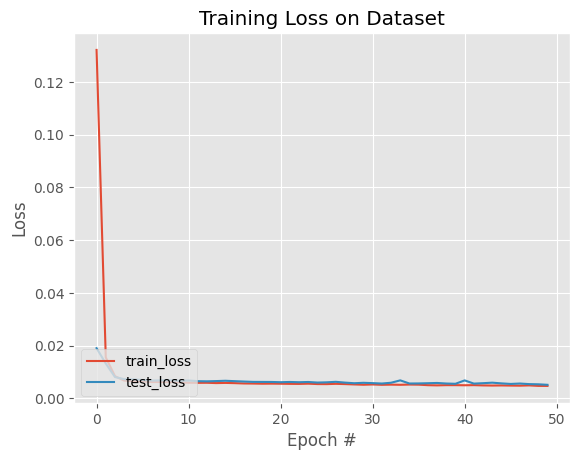

In [ ]:
# Plot the training loss

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

# Serialize the model to disk
MODEL_PATH = os.path.join(BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.pth".format(TEST_NAME, parameter, n, b, THRESHOLD))
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.png".format(TEST_NAME, parameter, n, b, THRESHOLD)])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.txt".format(TEST_NAME, parameter, n, b, THRESHOLD)])
plt.savefig(PLOT_PATH)

# Saving the results
torch.save(unet, MODEL_PATH)

# Function for seeing the results with the ground truth


In [ ]:

def prepare_plot(origImage, origMask, predMask, thMask):

	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	ax[3].imshow(thMask)

	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("GT Mask")
	ax[2].set_title("Predicted Mask")
	ax[3].set_title("Threshold Mask")

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

def make_predictions(model, imagePath, maskPath, THRESHOLD, save_Path, show = False, save = True):
	# set model to evaluation mode
	model.eval()

	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		nombre = os.path.basename(imagePath)[:-4]
		image = cv2.imread(imagePath)
		if save:
			cv2.imwrite(save_Path + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/original/" + nombre + ".png" , image)

		# Mask time
		inicio = time.time()
		mask1 = mask_simple(image)
		fin = time.time()
		time_mask_simple = fin - inicio

		# Mask time
		inicio = time.time()
		mask1 = mask_complex(image)
		fin = time.time()
		time_mask_complex = fin - inicio


		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		#image = cv2.resize(image, (128, 128))
		orig = image.copy()

		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]


		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(maskPath)


		#gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT,
			#INPUT_IMAGE_HEIGHT))

  		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device

		# NET time
		inicio1 = time.time()
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)

		image = torch.from_numpy(image).to(DEVICE)

		inicio2 = time.time()
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask) 		# make the prediction, pass the results through the sigmoid
		fin2 = time.time()

		predMask = predMask.cpu().numpy()     # function, and convert the result to a NumPy array
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		fin1 = time.time()
		tiempo_net1 = fin1 - inicio1
		tiempo_net2 = fin2 - inicio2

		# Saving all the results in the output
		if save:
			cv2.imwrite(save_Path + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/predicted_{}/".format(THRESHOLD) + nombre + ".png", predMask)
			cv2.imwrite(save_Path + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/mask/" + nombre + ".png" , gtMask)
			cv2.imwrite(save_Path + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/threshold/" + nombre + ".png" , mask1)

		# prepare a plot for visualization
		if show:
			prepare_plot(orig, gtMask, predMask, mask1)

	return time_mask_simple, time_mask_complex , tiempo_net1, tiempo_net2




# Function for seeing the results without the ground truth


In [ ]:
def prepare_plot_withoutgt(origImage, predMask, thMask):

	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(predMask)
	ax[2].imshow(thMask)

	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Threshold Mask")

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()


def make_predictions_withoutgt(model, imagePath, THRESHOLD, save_Path, show = False, save = True):

	# set model to evaluation mode
	model.eval()

	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		nombre = os.path.basename(imagePath)[:-4]
		image = cv2.imread(imagePath)
		if save:
			cv2.imwrite(save_Path + "/pre_trained_MOLA/output_syntetic_" + TEST_NAME + "/original/" + nombre + ".png" , image)

		# Mask time
		inicio = time.time()
		mask1 = mask_simple(image)
		fin = time.time()
		time_mask_simple = fin - inicio

		# Mask time
		inicio = time.time()
		mask1 = mask_complex(image)
		fin = time.time()
		time_mask_complex = fin - inicio


		image = image.astype("float32") / 255.0


		# resize the image and make a copy of it for visualization
		#image = cv2.resize(image, (128, 128))
		orig = image.copy()


  		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		# NET time
		inicio1 = time.time()
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)

		image = torch.from_numpy(image).to(DEVICE)

		inicio2 = time.time()
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask) 		# make the prediction, pass the results through the sigmoid
		fin2 = time.time()

		predMask = predMask.cpu().numpy()     # function, and convert the result to a NumPy array
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		fin1 = time.time()
		tiempo_net1 = fin1 - inicio1
		tiempo_net2 = fin2 - inicio2

		# Saving all the results in the output
		if save:
			cv2.imwrite(save_Path + "/pre_trained_MOLA/output_syntetic_" + TEST_NAME +  "/predicted_{}/".format(THRESHOLD) + nombre + ".png", predMask)
			cv2.imwrite(save_Path + "/pre_trained_MOLA/output_syntetic_" + TEST_NAME +  "/threshold/" + nombre + ".png" , mask1)

		# prepare a plot for visualization
		if show:
			prepare_plot_withoutgt(orig, predMask, mask1)

	return time_mask_simple, time_mask_complex , tiempo_net1, tiempo_net2



# Testing


In [ ]:
print("Until here, we are using the {} threshold".format(THRESHOLD))

Until here, we are using the 0.15 threshold


We can change the threshold, in this case thats the value with better results


In [ ]:
THRESHOLD = 0.15

### Loading the Net

Different types of masks fot the images. I did this because I wanted to measure the time of computing this masks.


In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths

def mask_simple(imagen):

  hsv_cam2 = cv2.cvtColor(imagen ,cv2.COLOR_BGR2HSV)
  mask1 = cv2.inRange(hsv_cam2, (0, 100, 0), (255, 255 ,255))

  return mask1

def mask_complex(img):

  back = np.zeros(img.shape[0:2])
  hsv_cam2 = cv2.cvtColor(img ,cv2.COLOR_BGR2HSV)
  mask1 = cv2.inRange(hsv_cam2, ( 0, 100, 0), (255, 255,255))
  back[10:1070, :] = mask1[10:1070, :]

  return back

print("[INFO] loading up test image paths...")
MODEL_PATH = os.path.join(BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.pth".format(TEST_NAME, parameter, n, b, THRESHOLD))
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.png".format(TEST_NAME, parameter, n, b, THRESHOLD)])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "Type_{}:PW_{}:E_{}:B_{}:TH_{}.txt".format(TEST_NAME, parameter, n, b, THRESHOLD)])
\
# load our model from disk and flash it to the current device
print("[INFO] load up model...")

unet = torch.load(MODEL_PATH, map_location ='cpu').to(DEVICE)

# iterate over the randomly selected test image paths

"""
The test paths are defined to test the neural network

This one is for the testing with the type of the syntetic images
imagePaths = glob.glob("/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Calibrations/rectify_images_dark/*.png")

This one is for the testing with the MOLA data
imagePathsTest = glob.glob("/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Simulated_terrain/light_images/*.png")

This one is for the testing with the MOLA data
imagePathsMOLA = glob.glob("/content/drive/Shareddrives/CoMPAS_MBARI_DATA/RAW/MBARI/MOLA/d20221220t1/d20221220t2_lidar_9m/images_SHGINF_S001_S001_T020/*.png")

"""

# They were defined at the beggining
imagePathsMask = y_validation
imagePathsTest = x_validation
imagePathsMOLA = glob.glob("/content/drive/Shareddrives/CoMPAS_MBARI_DATA/RAW/MBARI/MOLA/20230216t2/20230216-laser-calibration/images/MOLA/*.jpg")[0:3] + glob.glob("/content/drive/Shareddrives/CoMPAS_MBARI_DATA/RAW/MBARI/MOLA/20230216t2/20230216-laser-calibration/images/MOLA/*.jpg")[-3:]


[INFO] loading up test image paths...
[INFO] load up model...


In [ ]:
# Loop for the testing
time_masksimple_test = 0
time_maskcomplex_test = 0
time_netcomplex_test = 0
time_netsimple_test  = 0

print("We are using the {} threshold".format(THRESHOLD))
for path, mask_path in tqdm(zip(imagePathsTest,imagePathsMask)):

	time_mask_simple, time_mask_complex , tiempo_net1, tiempo_net2 = make_predictions(unet, path, mask_path, THRESHOLD, SAVE_PATH, show = False, save =False)
	time_masksimple_test += time_mask_simple
	time_maskcomplex_test += time_mask_complex
	time_netcomplex_test += tiempo_net1
	time_netsimple_test += tiempo_net2

print("The simple mask time is: ", time_masksimple_test, " and the complex mask is: ", time_maskcomplex_test, "in ", len(imagePathsTest), " images")
print("The simple net time is: ", time_netsimple_test, " and the complex net time is: ", time_netcomplex_test, "in ", len(imagePathsTest), " images")

We are using the 0.15 threshold


44it [00:11,  3.78it/s]

The simple mask time is:  0.16044211387634277  and the complex mask is:  0.31940770149230957 in  44  images
The simple net time is:  0.08651256561279297  and the complex net time is:  3.8893799781799316 in  44  images


We are using the 0.15 threshold


 17%|█▋        | 1/6 [00:03<00:16,  3.30s/it]


KeyboardInterrupt: ignored

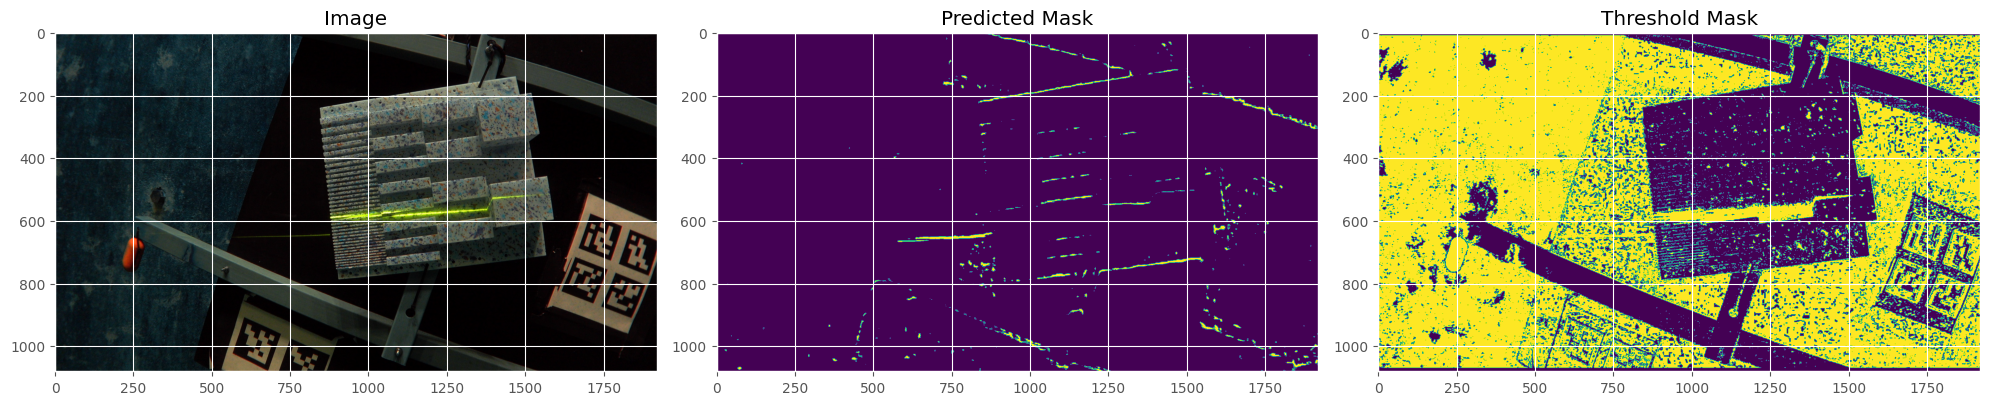

In [ ]:
# Loop for the MOLA dataset
time_masksimple_MOLA = 0
time_maskcomplex_MOLA = 0
time_netcomplex_MOLA = 0
time_netsimple_MOLA  = 0

print("We are using the {} threshold".format(THRESHOLD))
for path in tqdm(imagePathsMOLA):

	time_mask_simple, time_mask_complex , tiempo_net1, tiempo_net2 = make_predictions_withoutgt(unet, path, THRESHOLD, SAVE_PATH, show = True)
	time_masksimple_MOLA += time_mask_simple
	time_maskcomplex_MOLA += time_mask_complex
	time_netcomplex_MOLA += tiempo_net1
	time_netsimple_MOLA += tiempo_net2

print("The simple mask time is: ", time_masksimple_MOLA, " and the complex mask is: ", time_maskcomplex_MOLA, "in ", len(imagePathsMOLA), " images")
print("The simple net time is: ", time_netsimple_MOLA, " and the complex net time is: ", time_netcomplex_MOLA, "in ", len(imagePathsMOLA), " images")

# Defining functions for computing the results

In [ ]:
def confusion_matrix(real_image, predicted_image):
  real_image = cv2.imread(real_image,0)
  predicted_image = cv2.imread(predicted_image,0)

  H_real, W_real= real_image.shape
  H, W = predicted_image.shape
  blanco_blanco = 0
  negro_negro = 0
  blanco_negro = 0
  negro_blanco = 0

  if H_real == H and W_real == W:
    for fila in range(H):
      for col in range(W):
        if real_image[fila][col] == predicted_image[fila][col] and real_image[fila][col] == 255:
          blanco_blanco += 1
        elif real_image[fila][col] == predicted_image[fila][col] and real_image[fila][col] == 0:
          negro_negro += 1
        elif real_image[fila][col] != predicted_image[fila][col] and real_image[fila][col] == 255:
          blanco_negro += 1
        elif real_image[fila][col] != predicted_image[fila][col] and real_image[fila][col] == 0:
          negro_blanco += 1

  return blanco_blanco, negro_negro, blanco_negro, negro_blanco


def one_line_pixels(mask_original, mask_predicted):
    # Load the original and predicted masks
    mask_original = cv2.imread(mask_original, 0)
    mask_predicted = cv2.imread(mask_predicted, 0)

    # Compute the average white pixel coordinates for each column in both masks
    points_cam1 = []
    points_cam2 = []
    for i in range(mask_original.shape[1]):
        # Find the white pixels in the current column of each mask
        p_cam1 = np.where(mask_original[:, i] > 0)[0]
        p_cam2 = np.where(mask_predicted[:, i] > 0)[0]

        # Compute the average pixel coordinates for each mask in the current column
        avg_cam1 = round(np.mean(p_cam1)) if len(p_cam1) > 0 else np.nan
        avg_cam2 = round(np.mean(p_cam2)) if len(p_cam2) > 0 else np.nan

        # Add the average coordinates to the list for each mask
        points_cam1.append((i, avg_cam1))
        points_cam2.append((i, avg_cam2))

    return points_cam1, points_cam2


def distancee(real_points, estimate_points, img):

  diference = 0
  nan = 0
  i = 0
  for point in range(len(real_points)):
    if np.isnan(real_points[point][1]- estimate_points[point][1])!= True:
      diference += (real_points[point][1]- estimate_points[point][1])**2
    else:
      nan += 1
    i += 1
  img = cv2.imread(img, 0)
  img1 = img.astype(float)

  return np.sqrt(diference)/(i - nan), np.sqrt(diference), nan/i*100

def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    #img1 = normalize(img1)
    #img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    #cv2_imshow(diff)
    m_norm = sum(abs(diff))  # Manhattan norm

    z_norm = norm(diff.ravel(), 0)
   # Zero norm
    return (m_norm, z_norm)

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()

    #Cuando la imagen es entera negra se indefine
    return (arr-amin)*255/rng

def norms_distances(mask_cam1, mask_cam2):
  mask_cam1 = cv2.imread(mask_cam1, 0)
  mask_cam2 = cv2.imread(mask_cam2, 0)
  img1 = mask_cam1.astype(float)
  img2 = mask_cam2.astype(float)
#  print("Shape imagen 1 y 2 ", img1.shape, img2.shape)

  # compare
  n_m, n_0 = compare_images(img1, img2)
#  print("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size)
#  print("Zero norm:", n_0, "/ per pixel:", n_0*1.0/img1.size)
  return n_m, n_m/img1.size, n_0, n_0*1.0/img1.size

def create_image_from_points(points_cam, img_width, img_height):
    # Create a blank image with the specified width and height
    img = np.zeros((img_height, img_width), dtype=np.uint8)

    # Draw a white pixel at the average y-coordinate of each column
    for x, y in points_cam:
        if not np.isnan(y):
            img[int(y), x] = 255

    return img

def point_distance(points1, points2):
    from scipy.spatial import distance
    points1 = np.array(points1)
    points2 = np.array(points2)

    # Remove points with nan values
    mask1 = ~np.apply_along_axis(np.isnan, 1, points1).any(axis=1)
    mask2 = ~np.apply_along_axis(np.isnan, 1, points2).any(axis=1)
    points1 = points1[mask1]
    points2 = points2[mask2]

    # Check that there are still points remaining
    if len(points1) == 0 or len(points2) == 0:
        return np.nan

    if len(points1) == 0 and len(points2) == 0:
        return 0

    # Compute distance between remaining points
    results = distance.cdist(points1, points2, 'euclidean')
    distance = 0
    for fila in results:

        distance += np.min(fila)

    return distance/len(results)

def directed_hausdorff_modified(points1, points2):
    points1 = np.array(points1)
    points2 = np.array(points2)
    # Remove NaN values
    mask1 = ~np.apply_along_axis(np.isnan, 1, points1).any(axis=1)
    mask2 = ~np.apply_along_axis(np.isnan, 1, points2).any(axis=1)
    points1 = points1[mask1]
    points2 = points2[mask2]

    # Calculate directed Hausdorff distance
    d_hd1 = directed_hausdorff(points1, points2)[0]
    d_hd2 = directed_hausdorff(points2, points1)[0]
    return max(d_hd1, d_hd2)


# Computing the results MOLA

In [ ]:
# Reading images
original = glob.glob(SAVE_PATH  + "/pre_trained_MOLA/output_syntetic_" + TEST_NAME +  "/original/*.png")
prediction = glob.glob(SAVE_PATH + "/pre_trained_MOLA/output_syntetic_" + TEST_NAME +   "/predicted_{}/*.png".format(THRESHOLD))
threshold = glob.glob(SAVE_PATH + "/pre_trained_MOLA/output_syntetic_" + TEST_NAME + "/threshold/*.png")
mask = glob.glob("/content/drive/MyDrive/2021_FernandaLecaros/Tesis/Nets/LAB/pre_trained_MOLA/output_lab_illuminated/mask/*.png")

print(len(original), len(prediction), len(threshold))


6 6 6


In [ ]:

euclidean_distances = []
euclidean_normdistances = []
missing_pixeles = []
paths_original = []
paths_predicted = []
manhattan_norm = []
manhattan_normpp = []
zero_norm = []
zero_normpp = []
BB = []
NN = []
BN = []
NB = []
accuracy = []
precision = []
precision_average = []
recall = []
recall_average = []
f1 = []
f1_average =[]
distance_inv = []
housdorff = []


for original_mask, predicted_mask in tqdm(zip(mask, prediction )):
  a, b, c, d = confusion_matrix(original_mask, predicted_mask)
  e, f, g, h = norms_distances(original_mask, predicted_mask)
  paths_original.append(original_mask)
  paths_predicted.append(predicted_mask)
  real, predicted = one_line_pixels(original_mask, predicted_mask)

  euclidean_distances.append(distancee(real, predicted, original_mask)[1])
  euclidean_normdistances.append(distancee(real, predicted, original_mask)[0])

  missing_pixeles.append(distancee(real, predicted, original_mask)[2])
  BB.append(a)
  NN.append(b)
  BN.append(c)
  NB.append(d)
  manhattan_norm.append(e)
  manhattan_normpp.append(f)
  zero_norm.append(g)
  zero_normpp.append(h)
  if (a + b + c + d) != 0:
    accuracy.append((a+ b) * 100/(a + b + c + d))

  if a + d != 0:
    presition = a /(a +d)
    precision.append(a* 100 /(a + d))
    precision_average.append(a * 100 /(a + d))
  else:
     if c == 0:
        precision.append(100)
        precision_average.append(100)
        presition = 1
     else:
        precision.append(0)
        precision_average.append(0)
        presition = 0
  if a + c != 0:
    rcall = a /(a +  c)
    recall.append(a* 100 /(a + c))
    recall_average.append(a * 100 /(a + c))
  else:
     if d == 0:
        recall.append(100)
        recall_average.append(100)
        rcall = 1
     else:
        recall.append(0)
        recall_average.append(0)
        rcall = 0
  if presition + rcall != 0:
    f1.append(2*(presition * rcall /(presition + rcall)))
    f1_average.append(2*(presition * rcall /(presition + rcall)))
  else:
    f1.append(0)
    f1_average.append(0)

  distance_inv.append((point_distance(real, predicted) , point_distance(predicted, real), (point_distance(real, predicted) + point_distance(predicted, real))/2))
  housdorff.append(directed_hausdorff_modified(real, predicted))


0it [00:00, ?it/s]<ipython-input-16-1996fa046430>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  m_norm = sum(abs(diff))  # Manhattan norm
3it [00:29,  9.96s/it]

In [ ]:
# Main values for the dataset

euclidean_distances.insert(0, np.average(euclidean_distances))
euclidean_normdistances.insert(0, np.average(euclidean_normdistances))
missing_pixeles.insert(0, np.average(missing_pixeles))
paths_original.insert(0, "-")
paths_predicted.insert(0, "-")
manhattan_norm.insert(0, np.average(manhattan_norm))
manhattan_normpp.insert(0, np.average(manhattan_normpp))
zero_norm.insert(0, np.average(zero_norm))
zero_normpp.insert(0, np.average(zero_normpp))
BB.insert(0, np.average(BB))
NN.insert(0, np.average(NN))
BN.insert(0, np.average(BN))
NB.insert(0, np.average(NB))
accuracy.insert(0, np.average(accuracy))
precision.insert(0, np.average(precision_average))
recall.insert(0, np.average(recall_average))

f1.insert(0, np.average(f1_average))
d1 = [distance_inv[0] for i in distance_inv]
d2 = [distance_inv[1] for i in distance_inv]
d3 = [distance_inv[2] for i in distance_inv]
distance_inv.insert(0, (np.average(d1), np.average(d2), np.average(d3)))
housdorff.insert(0, np.average(housdorff))


In [ ]:
# Setting the metrics in the excel

data = {"Test path original": paths_original,
        "Test path predicted": paths_predicted,
        "Test split": np.repeat(TEST_SPLIT, len(euclidean_distances)),
        "Learning rate": np.repeat(INIT_LR, len(euclidean_distances)),
        "Number epochs": np.repeat(NUM_EPOCHS, len(euclidean_distances)),
        "Batch size":np.repeat(BATCH_SIZE, len(euclidean_distances)),
        "Image width": np.repeat(INPUT_IMAGE_WIDTH, len(euclidean_distances)),
        "Image Height": np.repeat(INPUT_IMAGE_HEIGHT, len(euclidean_distances)),
        "Threshold": np.repeat(THRESHOLD, len(euclidean_distances)),
        "F1": f1,
        "Distance bi":distance_inv,
        "Housedorff": housdorff,
        'Euclidean distance': euclidean_distances,
        'Norm Euclidean distance': euclidean_normdistances,
        "Missing pixeles": missing_pixeles,
        "Manhattan norm per pixel": manhattan_normpp,
        'BB': BB,
        "NN":NN,
        "BN": BN,
        "NB": NB,
        "Manhattan norm": manhattan_norm,
        "Zero norm": zero_norm,
        "Zero norm per pixel": zero_normpp,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
        }

print(len(paths_original), len(missing_pixeles), len(precision), len(accuracy))
df = pd.DataFrame(data, columns = ['Test path original',
                                   'Test path predicted',
                                   "Test split",
                                    "Learning rate",
                                    "Number epochs",
                                    "Batch size",
                                    "Image width",
                                    "Image Height",
                                    "Threshold",
                                    "F1",
                                    "Distance bi",
                                    "Housedorff",
                                    'Euclidean distance',
                                    'Norm Euclidean distance',
                                    "Missing pixeles",
                                    "Manhattan norm per pixel",
                                    'BB',
                                    "NN",
                                    "BN",
                                    "NB",
                                    "Manhattan norm",
                                    "Zero norm",
                                    "Zero norm per pixel",
                                    "Accuracy",
                                    "Precision",
                                    "Recall"])

## Saving the results in a excel


In [ ]:
# Writing the results in the Excel
excel_book = pxl.load_workbook(BASE_OUTPUT + "/pre_trained_MOLA/Results_{}.xlsx".format(TEST_NAME))
with pd.ExcelWriter(BASE_OUTPUT + "/pre_trained_MOLA/Results_{}.xlsx".format(TEST_NAME), engine='openpyxl') as writer:
    writer.book = excel_book
    writer.sheets = {
        worksheet.title: worksheet
        for worksheet in excel_book.worksheets
    }
    secondMockData = data
    secondMockDF = pd.DataFrame(secondMockData)
    secondMockDF.to_excel(writer,"Ner " + str(THRESHOLD)  , index=False)
    writer.save()

    print(THRESHOLD)

# Computing the results for testing

In [ ]:
# Reading images
original = glob.glob(SAVE_PATH  + "/pre_trained_test/output_syntetic_" + TEST_NAME +  "/original/*.png")
prediction = glob.glob(SAVE_PATH + "/pre_trained_test/output_syntetic_" + TEST_NAME +   "/predicted_{}/*.png".format(THRESHOLD))
mask = glob.glob(SAVE_PATH + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/mask/*.png")
threshold = glob.glob(SAVE_PATH + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/threshold/*.png")

print(len(original), len(prediction), len(mask), len(threshold))
print(THRESHOLD)

44 44 44 44
0.15


## Comparing the gt with the prediction

In [ ]:

euclidean_distances = []
euclidean_normdistances = []
missing_pixeles = []
paths_original = []
paths_predicted = []
manhattan_norm = []
manhattan_normpp = []
zero_norm = []
zero_normpp = []
BB = []
NN = []
BN = []
NB = []
accuracy = []
precision = []
precision_average = []
recall = []
recall_average = []
f1 = []
f1_average =[]
distance_inv = []
housdorff = []


for original_mask in tqdm(mask):
  name = os.path.basename(original_mask)
  predicted_mask = SAVE_PATH + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/predicted_{}/".format(THRESHOLD) + name
  a, b, c, d = confusion_matrix(original_mask, predicted_mask)
  e, f, g, h = norms_distances(original_mask, predicted_mask)
  paths_original.append(original_mask)
  paths_predicted.append(predicted_mask)
  real, predicted = one_line_pixels(original_mask, predicted_mask)

  euclidean_distances.append(distancee(real, predicted, original_mask)[1])
  euclidean_normdistances.append(distancee(real, predicted, original_mask)[0])

  missing_pixeles.append(distancee(real, predicted, original_mask)[2])
  BB.append(a)
  NN.append(b)
  BN.append(c)
  NB.append(d)
  manhattan_norm.append(e)
  manhattan_normpp.append(f)
  zero_norm.append(g)
  zero_normpp.append(h)
  if (a + b + c + d) != 0:
    accuracy.append((a+ b) * 100/(a + b + c + d))

  if a + d != 0:
    presition = a /(a +d)
    precision.append(a* 100 /(a + d))
    precision_average.append(a * 100 /(a + d))
  else:
     if c == 0:
        precision.append(100)
        precision_average.append(100)
        presition = 1
     else:
        precision.append(0)
        precision_average.append(0)
        presition = 0
  if a + c != 0:
    rcall = a /(a +  c)
    recall.append(a* 100 /(a + c))
    recall_average.append(a * 100 /(a + c))
  else:
     if d == 0:
        recall.append(100)
        recall_average.append(100)
        rcall = 1
     else:
        recall.append(0)
        recall_average.append(0)
        rcall = 0
  if presition + rcall != 0:
    f1.append(2*(presition * rcall /(presition + rcall)))
    f1_average.append(2*(presition * rcall /(presition + rcall)))
  else:
    f1.append(0)
    f1_average.append(0)

  distance_inv.append((point_distance(real, predicted) , point_distance(predicted, real), (point_distance(real, predicted) + point_distance(predicted, real))/2))
  housdorff.append(directed_hausdorff_modified(real, predicted))

  0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-41-1996fa046430>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  m_norm = sum(abs(diff))  # Manhattan norm
 20%|██        | 9/44 [01:23<05:25,  9.30s/it]<ipython-input-41-1996fa046430>:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(diference)/(i - nan), np.sqrt(diference), nan/i*100
100%|██████████| 44/44 [06:53<00:00,  9.39s/it]


In [ ]:
# Main values for the dataset

euclidean_distances.insert(0, np.average(euclidean_distances))
euclidean_normdistances.insert(0, np.average(euclidean_normdistances))
missing_pixeles.insert(0, np.average(missing_pixeles))
paths_original.insert(0, "-")
paths_predicted.insert(0, "-")
manhattan_norm.insert(0, np.average(manhattan_norm))
manhattan_normpp.insert(0, np.average(manhattan_normpp))
zero_norm.insert(0, np.average(zero_norm))
zero_normpp.insert(0, np.average(zero_normpp))
BB.insert(0, np.average(BB))
NN.insert(0, np.average(NN))
BN.insert(0, np.average(BN))
NB.insert(0, np.average(NB))
accuracy.insert(0, np.average(accuracy))
precision.insert(0, np.average(precision_average))
recall.insert(0, np.average(recall_average))

f1.insert(0, np.average(f1_average))
d1 = [distance_inv[0] for i in distance_inv]
d2 = [distance_inv[1] for i in distance_inv]
d3 = [distance_inv[2] for i in distance_inv]
distance_inv.insert(0, (np.average(d1), np.average(d2), np.average(d3)))
housdorff.insert(0, np.average(housdorff))


In [ ]:
# Setting the metrics in the excel

data = {"Test path original": paths_original,
        "Test path predicted": paths_predicted,
        "Test split": np.repeat(TEST_SPLIT, len(euclidean_distances)),
        "Learning rate": np.repeat(INIT_LR, len(euclidean_distances)),
        "Number epochs": np.repeat(NUM_EPOCHS, len(euclidean_distances)),
        "Batch size":np.repeat(BATCH_SIZE, len(euclidean_distances)),
        "Image width": np.repeat(INPUT_IMAGE_WIDTH, len(euclidean_distances)),
        "Image Height": np.repeat(INPUT_IMAGE_HEIGHT, len(euclidean_distances)),
        "Threshold": np.repeat(THRESHOLD, len(euclidean_distances)),
        "F1": f1,
        "Distance bi":distance_inv,
        "Housedorff": housdorff,
        'Euclidean distance': euclidean_distances,
        'Norm Euclidean distance': euclidean_normdistances,
        "Missing pixeles": missing_pixeles,
        "Manhattan norm per pixel": manhattan_normpp,
        'BB': BB,
        "NN":NN,
        "BN": BN,
        "NB": NB,
        "Manhattan norm": manhattan_norm,
        "Zero norm": zero_norm,
        "Zero norm per pixel": zero_normpp,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
        }

print(len(paths_original), len(missing_pixeles), len(precision), len(accuracy))
df = pd.DataFrame(data, columns = ['Test path original',
                                   'Test path predicted',
                                   "Test split",
                                    "Learning rate",
                                    "Number epochs",
                                    "Batch size",
                                    "Image width",
                                    "Image Height",
                                    "Threshold",
                                    "F1",
                                    "Distance bi",
                                    "Housedorff",
                                    'Euclidean distance',
                                    'Norm Euclidean distance',
                                    "Missing pixeles",
                                    "Manhattan norm per pixel",
                                    'BB',
                                    "NN",
                                    "BN",
                                    "NB",
                                    "Manhattan norm",
                                    "Zero norm",
                                    "Zero norm per pixel",
                                    "Accuracy",
                                    "Precision",
                                    "Recall"])

45 45 45 45


## Saving the results

In [ ]:
# Writing the results in the Excel
excel_book = pxl.load_workbook(BASE_OUTPUT + "/pre_trained_test/Results_{}.xlsx".format(TEST_NAME))
with pd.ExcelWriter(BASE_OUTPUT + "/pre_trained_test/Results_{}.xlsx".format(TEST_NAME), engine='openpyxl') as writer:
    writer.book = excel_book
    writer.sheets = {
        worksheet.title: worksheet
        for worksheet in excel_book.worksheets
    }
    secondMockData = data
    secondMockDF = pd.DataFrame(secondMockData)
    secondMockDF.to_excel(writer,"Testing predictions " + str(THRESHOLD)  , index=False)
    writer.save()

    print(THRESHOLD)

0.15


## Comapring the gt with threshold


In [ ]:

euclidean_distances = []
euclidean_normdistances = []
missing_pixeles = []
paths_original = []
paths_predicted = []
manhattan_norm = []
manhattan_normpp = []
zero_norm = []
zero_normpp = []
BB = []
NN = []
BN = []
NB = []
accuracy = []
precision = []
precision_average = []
recall = []
recall_average = []
f1 = []
f1_average =[]
distance_inv = []
housdorff = []


for original_mask in tqdm(mask):
  name = os.path.basename(original_mask)
  predicted_mask = SAVE_PATH + "/pre_trained_test/output_syntetic_" + TEST_NAME + "/threshold/" + name
  a, b, c, d = confusion_matrix(original_mask, predicted_mask)
  e, f, g, h = norms_distances(original_mask, predicted_mask)
  paths_original.append(original_mask)
  paths_predicted.append(predicted_mask)
  real, predicted = one_line_pixels(original_mask, predicted_mask)


  euclidean_distances.append(distancee(real, predicted, original_mask)[1])
  euclidean_normdistances.append(distancee(real, predicted, original_mask)[0])

  missing_pixeles.append(distancee(real, predicted, original_mask)[2])
  BB.append(a)
  NN.append(b)
  BN.append(c)
  NB.append(d)
  manhattan_norm.append(e)
  manhattan_normpp.append(f)
  zero_norm.append(g)
  zero_normpp.append(h)
  if (a + b + c + d) != 0:
    accuracy.append((a+ b) * 100/(a + b + c + d))

  if a + d != 0:
    presition = a /(a +d)
    precision.append(a* 100 /(a + d))
    precision_average.append(a * 100 /(a + d))
  else:
     precision.append(0)
     precision_average.append(0)
     presition = 0
  if a + c != 0:
    rcall = a /(a +  c)
    recall.append(a* 100 /(a + c))
    recall_average.append(a * 100 /(a + c))
  else:
     recall.append(0)
     recall_average.append(0)
     rcall = 0
  if presition + rcall != 0:
    f1.append(2*(presition * rcall /(presition + rcall)))
    f1_average.append(2*(presition * rcall /(presition + rcall)))
  else:
    f1.append(0)
    f1_average.append(0)

  distance_inv.append((point_distance(real, predicted) , point_distance(predicted, real), (point_distance(real, predicted) + point_distance(predicted, real))/2))
  housdorff.append(directed_hausdorff_modified(real, predicted))

  0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-41-1996fa046430>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  m_norm = sum(abs(diff))  # Manhattan norm
 20%|██        | 9/44 [01:24<05:27,  9.37s/it]<ipython-input-41-1996fa046430>:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(diference)/(i - nan), np.sqrt(diference), nan/i*100
100%|██████████| 44/44 [06:53<00:00,  9.40s/it]


In [ ]:
# Main values for the dataset

euclidean_distances.insert(0, np.average(euclidean_distances))
euclidean_normdistances.insert(0, np.average(euclidean_normdistances))
missing_pixeles.insert(0, np.average(missing_pixeles))
paths_original.insert(0, "-")
paths_predicted.insert(0, "-")
manhattan_norm.insert(0, np.average(manhattan_norm))
manhattan_normpp.insert(0, np.average(manhattan_normpp))
zero_norm.insert(0, np.average(zero_norm))
zero_normpp.insert(0, np.average(zero_normpp))
BB.insert(0, np.average(BB))
NN.insert(0, np.average(NN))
BN.insert(0, np.average(BN))
NB.insert(0, np.average(NB))
accuracy.insert(0, np.average(accuracy))
precision.insert(0, np.average(precision_average))
recall.insert(0, np.average(recall_average))

f1.insert(0, np.average(f1_average))
d1 = [distance_inv[0] for i in distance_inv]
d2 = [distance_inv[1] for i in distance_inv]
d3 = [distance_inv[2] for i in distance_inv]
distance_inv.insert(0, (np.average(d1), np.average(d2), np.average(d3)))
housdorff.insert(0, np.average(housdorff))

In [ ]:
# Setting the metrics in the excel

data = {"Test path original": paths_original,
        "Test path predicted": paths_predicted,
        "Test split": np.repeat(TEST_SPLIT, len(euclidean_distances)),
        "Learning rate": np.repeat(INIT_LR, len(euclidean_distances)),
        "Number epochs": np.repeat(NUM_EPOCHS, len(euclidean_distances)),
        "Batch size":np.repeat(BATCH_SIZE, len(euclidean_distances)),
        "Image width": np.repeat(INPUT_IMAGE_WIDTH, len(euclidean_distances)),
        "Image Height": np.repeat(INPUT_IMAGE_HEIGHT, len(euclidean_distances)),
        "Threshold": np.repeat(THRESHOLD, len(euclidean_distances)),
        "F1": f1,
        "Distance bi":distance_inv,
        "Housedorff": housdorff,
        'Euclidean distance': euclidean_distances,
        'Norm Euclidean distance': euclidean_normdistances,
        "Missing pixeles": missing_pixeles,
        "Manhattan norm per pixel": manhattan_normpp,
        'BB': BB,
        "NN":NN,
        "BN": BN,
        "NB": NB,
        "Manhattan norm": manhattan_norm,
        "Zero norm": zero_norm,
        "Zero norm per pixel": zero_normpp,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
        }

print(len(paths_original), len(missing_pixeles), len(precision), len(accuracy))
df = pd.DataFrame(data, columns = ['Test path original',
                                   'Test path predicted',
                                   "Test split",
                                    "Learning rate",
                                    "Number epochs",
                                    "Batch size",
                                    "Image width",
                                    "Image Height",
                                    "Threshold",
                                    "F1",
                                    "Distance bi",
                                    "Housedorff",
                                    'Euclidean distance',
                                    'Norm Euclidean distance',
                                    "Missing pixeles",
                                    "Manhattan norm per pixel",
                                    'BB',
                                    "NN",
                                    "BN",
                                    "NB",
                                    "Manhattan norm",
                                    "Zero norm",
                                    "Zero norm per pixel",
                                    "Accuracy",
                                    "Precision",
                                    "Recall"])

45 45 45 45


In [ ]:
# Writing the results in the Excel
excel_book = pxl.load_workbook(BASE_OUTPUT + "/pre_trained_test/Results_{}.xlsx".format(TEST_NAME))
with pd.ExcelWriter(BASE_OUTPUT + "/pre_trained_test/Results_{}.xlsx".format(TEST_NAME), engine='openpyxl') as writer:
    writer.book = excel_book
    writer.sheets = {
        worksheet.title: worksheet
        for worksheet in excel_book.worksheets
    }
    secondMockData = data
    secondMockDF = pd.DataFrame(secondMockData)
    secondMockDF.to_excel(writer,"Testing threshold " , index=False)
    writer.save()